# Retrieval Augmented Generation (RAG): Extracting Data from the NY Times

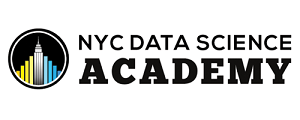

The NY Times provides an API that people can use to read and browse through published content. In this exercise, we will extract that data develop our own repository; we will be able to use this for retrieval augmented generation using a large language model. Our LLM of choice will be Gemini 2.5. This technique will allow us to imrpove responses made by a large language model by giving us the ability to feed the models context beforehand.

---

**This is the overall workflow-**

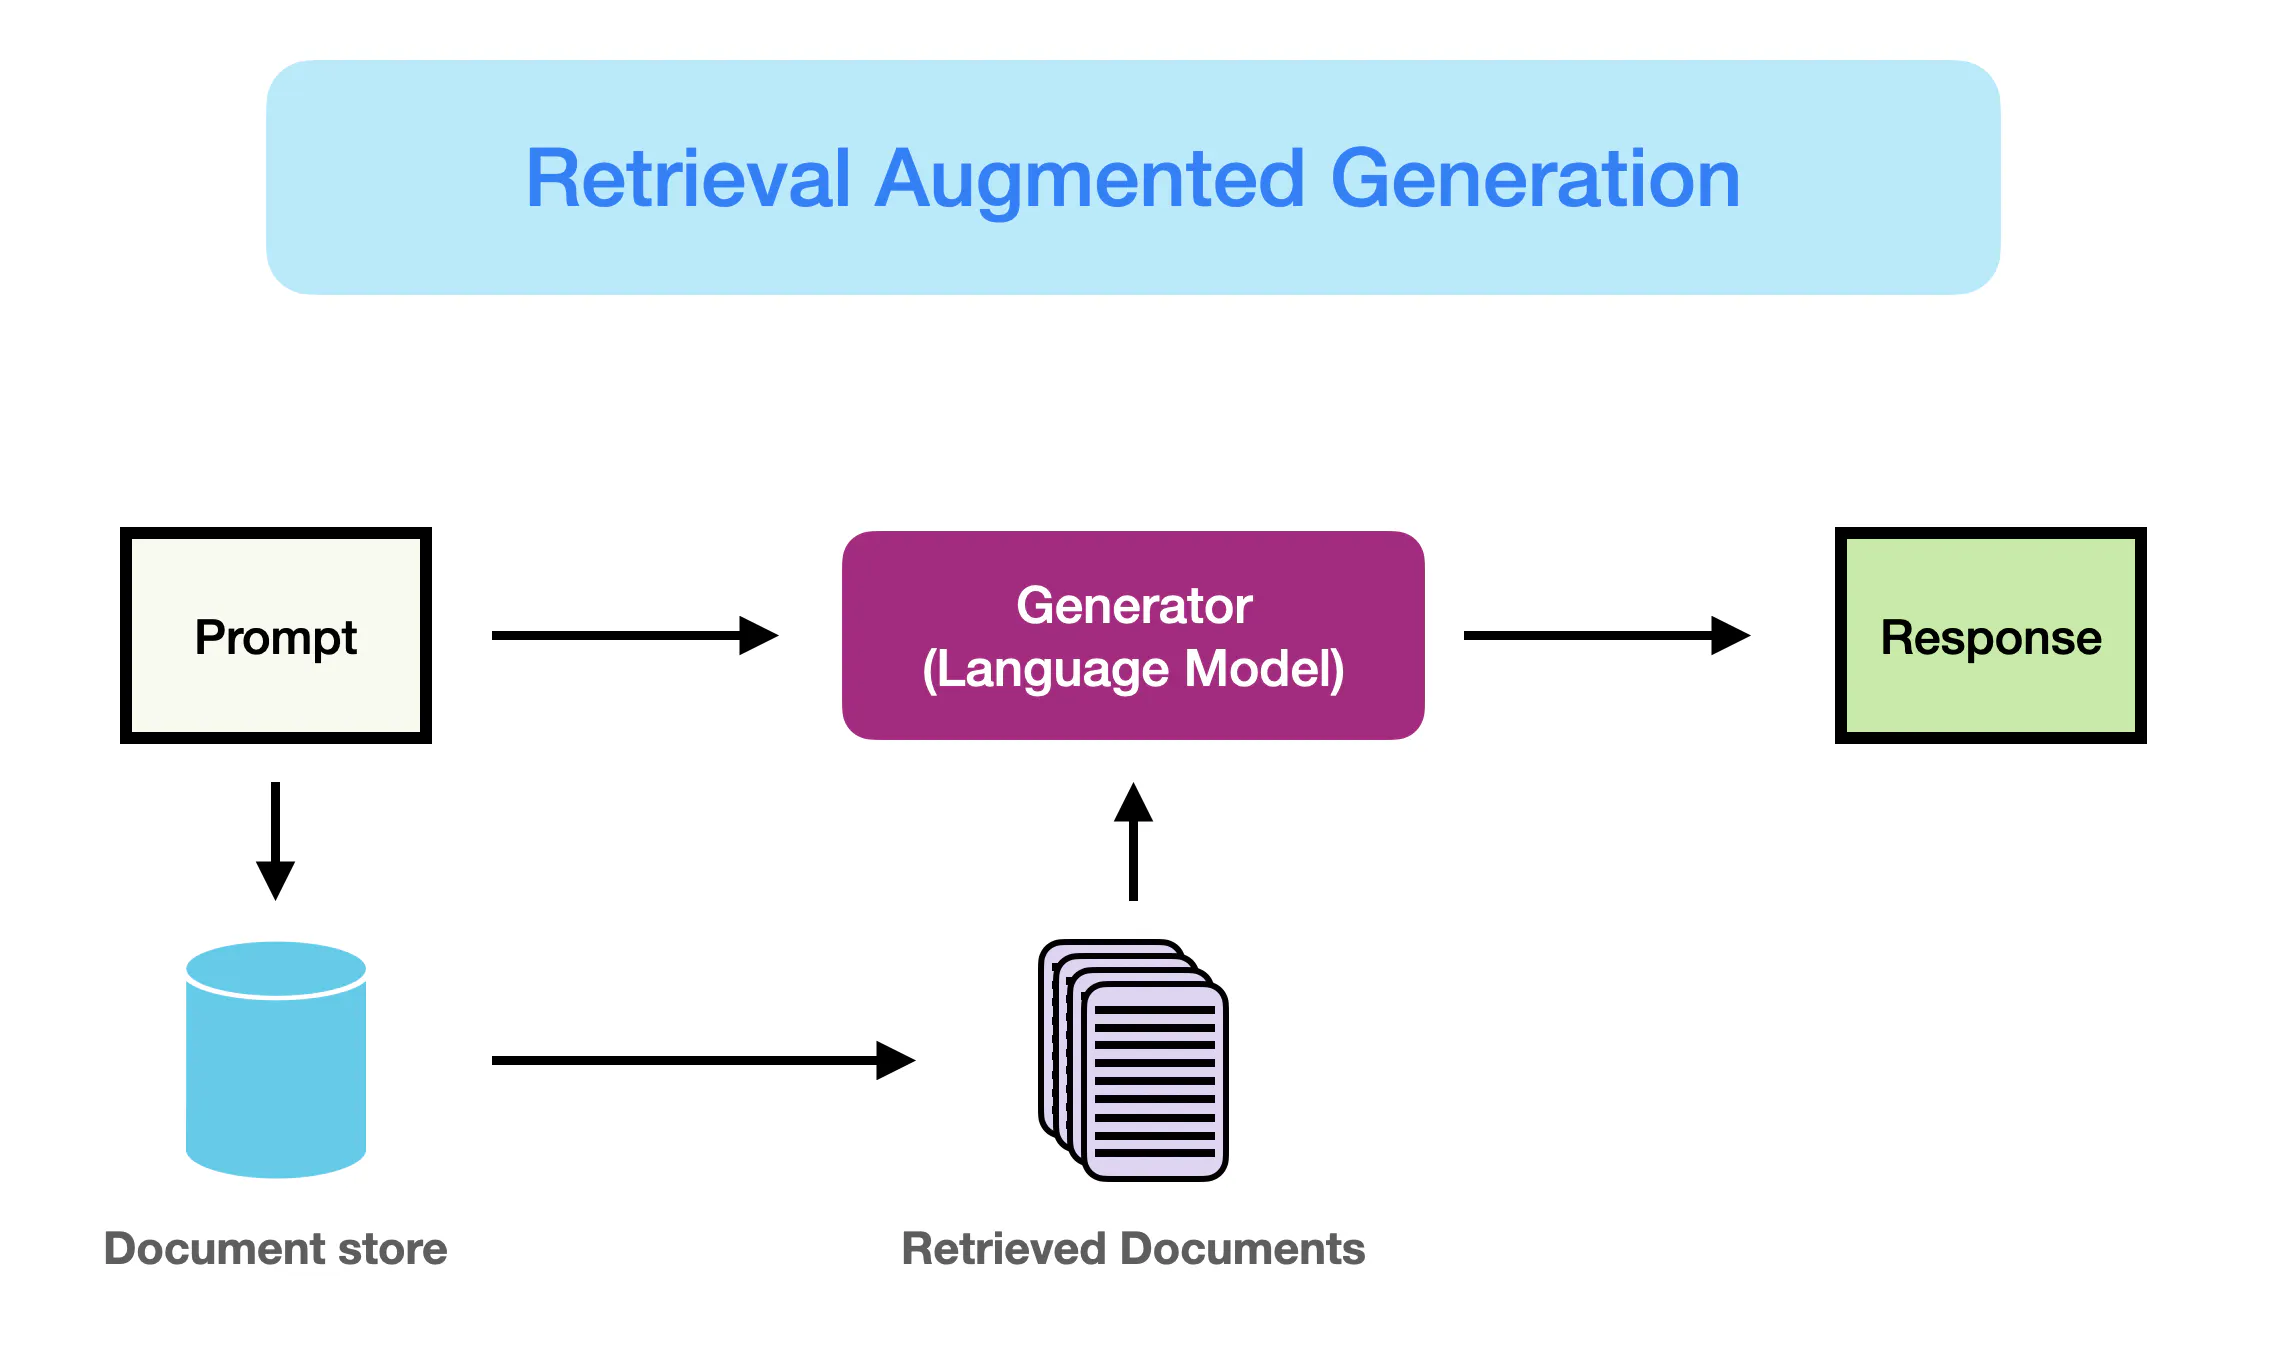


In [ ]:
%%capture

# Install packages
!pip install --upgrade pynytimes google-generativeai chromadb google-genai neo4j #weaviate-client

In [ ]:
# Import libraries
from pynytimes import NYTAPI
from datetime import datetime, timedelta
import pandas as pd
import ast
from tqdm.auto import tqdm
tqdm.pandas()
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from google import genai
from google.colab import userdata
from google.colab import drive
from chromadb import Documents, EmbeddingFunction, Embeddings
import chromadb
from google.genai import types
from IPython.display import Markdown
import numpy as np
from neo4j import GraphDatabase, basic_auth
import time

In [ ]:
drive.mount('/content/drive')

In [ ]:
# Init conn to neo4j
#driver = GraphDatabase.driver('bolt://18.209.228.104:7687', auth = basic_auth('neo4j', 'waists-bays-bunches'))
driver = GraphDatabase.driver("neo4j+s://5c36956d.databases.neo4j.io", auth = basic_auth('neo4j', 'j8OwRuLG0JY0HgTONVFE7c9jSAs4ynxtc0bIyPjSxHc'))

In [ ]:
# Init
nyt = NYTAPI("15MPlclMxKGuTa7WreSZ9IYcbjoo45sL", parse_dates = True)

In [ ]:
# Configure google access credetnaisl
#genai.configure(api_key = userdata.get('GOOGLE_API_KEY'))
genaiclient = genai.Client(api_key = userdata.get('GOOGLE_API_KEY'))

In [ ]:
# Init the embedding models for encoding text
embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
crossencoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
# Define time period of choice for extracting articles from
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 7, 1)
data = []

# Init the date
current_date = start_date

# Iterate
while current_date <= end_date:

    # Handle exceptions
    try:

        # Download article metadata
        df = nyt.archive_metadata(date = datetime(current_date.year, current_date.month, 1))

        print(f"Fetching Articles Metadata for: {current_date.date()}")

        current_date += timedelta(days = 32)
        current_date = current_date.replace(day = 1)

        # Store result
        data.append(df)

    except:

        break

In [ ]:
df = pd.DataFrame()

for d in data:

    f = pd.DataFrame(d).drop(['source', 'web_url', 'print_section', 'print_page', 'multimedia', '_id', 'word_count', 'uri', 'subsection_name'], axis = 1)

    df = pd.concat([df, f])

# Convert dicts
df['headline'] = df['headline'].progress_apply(lambda x: ast.literal_eval(str(x)), desc = 'Processing headlines..')
df['byline'] = df['byline'].progress_apply(lambda x: ast.literal_eval(str(x)), desc = 'Converting bylines..')

headlines = []

# Extract headlines
for x in df['headline']:

    if x['print_headline'] is not None:

        headlines.append(x['print_headline'])

    else:

        headlines.append('')

df['headline'] = headlines

# Combine text fields
df['text'] = df.apply(lambda row: f"{row['abstract']} {row['snippet']}" if row['abstract'] != row['snippet'] else row['abstract'], axis = 1)
df['text'] = df['text'] + ' ' + df['lead_paragraph'] + ' ' + df['headline']

# Reformat the dates
df['pub_date'] = df['pub_date'].apply(lambda x: x.strftime("%Y-%m-%d"))

df1 = df.drop(['abstract', 'snippet', 'lead_paragraph', 'headline', 'keywords', 'type_of_material'], axis = 1).reset_index().rename({'index': 'id'}, axis = 1)

df1['byline'] = df1['byline'].apply(lambda x: x['original'])

# Encode the text documents
df1['embeddings'] = df1['text'].progress_apply(lambda x: embedder.encode(x), desc = 'Performing vectorization of text..')

In [ ]:
df1.head()

In [ ]:
# Verify the connection to neo4j dataase
with GraphDatabase.driver("neo4j+s://5c36956d.databases.neo4j.io", auth = ('neo4j', 'j8OwRuLG0JY0HgTONVFE7c9jSAs4ynxtc0bIyPjSxHc')) as driver:

    driver.verify_connectivity()

In [ ]:
# Function to load data in batches
def execute_batch_upload(query, rows, batch_size = 500):

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = list(session.run(query, parameters = {'rows': rows[batch * batch_size:(batch + 1) * batch_size].to_dict('records')}))
        total += res[0]['total']
        batch += 1
        result = {"total": total,
                  "batches": batch,
                  "time": round(time.time() - start, 2)}

    print(result)

In [ ]:
# Functions to add users
def upload_data(rows):

    cypher = '''
                unwind $rows as row
                merge (n: node {pub_date: row.pub_date,
                                document_type: row.document_type,
                                news_desk: row.news_desk,
                                section_name: row.section_name,
                                byline: row.byline,
                                text: row.text,
                                embeddings: row.embeddings})
                return count(*) as total
             '''

    return execute_batch_upload(cypher, rows)

In [ ]:
# Function to execute neo4j ops
def conduct_neo_op(db, cypher):

    # Connect
    with driver.session(database = db) as sesh:

        # Handle exceptions
        try:

            out = list(sesh.run(cypher))
            return out

        except Exception as e:

            print('Query failed: ', e)

In [ ]:
# Function to execute semantic search
def execute_semantic_search(query, k = 100):

    # Encode the initial query
    query_embedding = embedder.encode(query)

    # Cypher to call index
    cypher = '''
                call db.index.vector.queryNodes('article_embeddings', $k, $query_embedding)
                yield node, score
                return node.pub_date, node.document_type, node.section_name, node.news_desk, node.byline, node.text, node.embeddings, score
             '''

    # Get result in df
    results = session.run(cypher, k = k, query_embedding = query_embedding)
    stage_one = pd.DataFrame(results.data())

    # Perform reranking
    reranking_input = [(query, x) for x in stage_one['node.text']]

    stage_one['reranked_score'] = crossencoder.predict(reranking_input)

    return stage_one.sort_values('reranked_score', ascending = False).head(n = 10)

In [ ]:
# Init graph
#with driver.session() as session:

    # Start db
#    try:

#        response = list(session.run('create or replace database articles'))
#        print('Database initialization has occurred..')

#    except Exception as e:

#        print("Query failed:", e)

#driver.close()

In [ ]:
%%time

# Add nodes to graph
with driver.session() as session:

    print('Loading data..')
    upload_data(df1)

driver.close()

In [ ]:
len(df1['embeddings'].iloc[0])

In [ ]:
# Create vector index in neo4j on the embeddings
cypher = '''
            create vector index article_embeddings if not exists
            for (n: node) on (n.embeddings)
            options {indexConfig: {`vector.dimensions`: 384, `vector.similarity_function`: 'cosine'}}
         '''

with driver.session() as session:

    try:

        session.run(cypher)
        print('Vector index "article_embeddings" has been created successfully..')

    except Exception as e:

        print(f"Error creating vector index: {e}")

driver.close()

In [ ]:
# Conduct similarity search
with driver.session() as session:

    print('Running stage one of semantic search..')

    res = execute_semantic_search('what were the main topics surrounding the recent election campaign cycle?')

In [ ]:
len(res)

In [ ]:
res

In [ ]:
# Extract results
#stage_one = pd.DataFrame(res)

# Rerank the initial results
#input_query = 'what were the main topics surrounding the recent election campaign cycle?'
#reranking_input = [(input_query, x) for x in stage_one['node.text']]
#stage_one['reranked_score'] = crossencoder.predict(reranking_input)

#stage_one.sort_values('reranked_score', ascending = False).head()

In [ ]:
# Conduct similarity search
with driver.session() as session:

    print('Running stage one of semantic search..')

    res = execute_semantic_search('do the houthis recieve any aid from iran?')

In [ ]:
res

In [ ]:
# Compile the prompt
query = 'do the houthis recieve any aid from iran?'

prompt = f'''
            You are a helpful assistant that has access to a New York Times database, use the following context retrieved from the data to respond to the user query.

            Query-
            {query}

            Context-
         '''

for idx, row in res.iterrows():

    context = f"{row['node.pub_date']}- {row['node.section_name']}, {row['node.news_desk']}: {row['node.byline']}, {row['node.text']}\n"
    prompt += context

In [ ]:
print(prompt)

In [ ]:
llmresponse = genaiclient.models.generate_content(model = 'gemini-2.5-flash', contents = prompt)

In [ ]:
print(llmresponse.text)

In [ ]:
# Download and install nvm:
# curl -o- https://raw.githubusercontent.com/nvm-sh/nvm/v0.40.3/install.sh | bash
# in lieu of restarting the shell
# \. "$HOME/.nvm/nvm.sh"
# Download and install Node.js:
# nvm install 22
# Verify the Node.js version:
# node -v # Should print "v22.16.0".
# nvm current # Should print "v22.16.0".
# Verify npm version:
# npm -v # Should print "10.9.2".